<a href="https://colab.research.google.com/github/grey52/Projects/blob/master/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F_UNet_%D0%B8_SigNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ эффективности архитектуры U-net и SegnNet c использованием различных loss функций



---

[ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>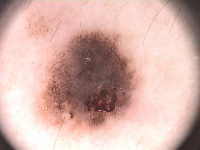</td><td>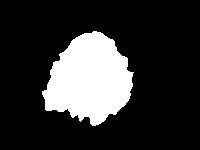</td></tr></table>
Датасет содержит различные фото мелоном и родинок

In [ ]:
! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2022-12-24 16:46:13--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2022-12-24 16:46:13--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca68cba9ccdfd348395d254456c.dl.dropboxusercontent.com/cd/0/inline/BzM9ijyXzKpr8h6bB1cQkRfnZftYUL-bOZ1mLJFEXjuthfyzFQw9rrQRSlEMow2daOmPYw1Z0uJRibGTQaFXSYRI0O_AjUv-dBI3QpxwodL2B7VIZJbJDzuEkvuTmoApRHWO40wh9KUFr7fYydUGH4R47iR8Cr2xIp3ApdG8yXRT1A/file# [following]
--2022-12-24 16:46:13--  https://uca68cba9ccdfd348395d254456c.dl.dropboxusercontent.com/cd/0/inline/BzM9ijyXzKpr8h6bB1cQkRfnZftYUL-bOZ1mLJFEXjuthfyzFQw9rrQRSlEMow2daOmPYw1Z0u

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры.Изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]


In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Убедимся,что все корректно, мы нарисуем несколько изображений

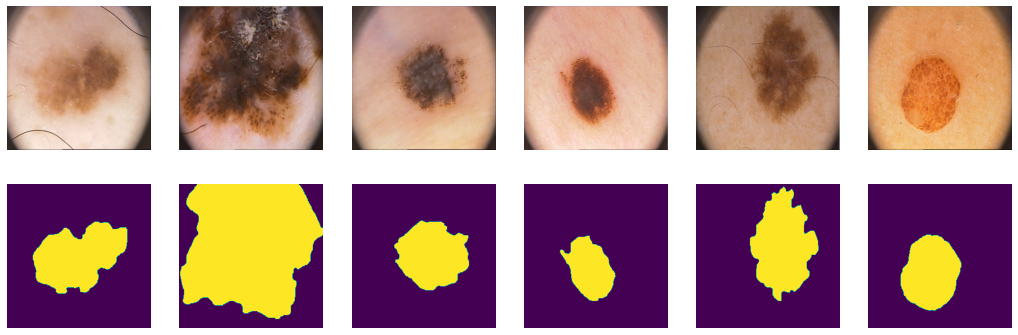

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 8
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация SegNet и U-net



## SegNet Курсив
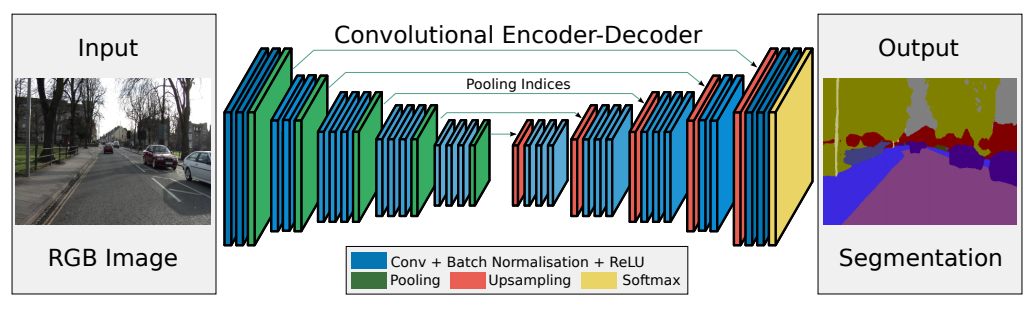

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(inplace=True),
                                )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(256),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.Conv2d(in_channels = 128, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                        )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
                            , nn.BatchNorm2d(1),

                        )

    def forward(self, x):
        x = x.to(device)

        e0, ind0 = self.pool0(self.enc_conv0(x))
 
        e1, ind1 = self.pool1(self.enc_conv1(e0))

        e2, ind2 = self.pool2(self.enc_conv2(e1))

        e3, ind3 = self.pool3(self.enc_conv3(e2))
     
        # bottleneck
        b = self.bottleneck_conv(e3)


        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))

        d1 = self.dec_conv1(self.upsample1(d0, ind2))

        d2 = self.dec_conv2(self.upsample2(d1, ind1))

        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation

        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    return thresholded  # 

## Функция потерь 
Для начала воспользуемся полпулярным методом для бинарной сегментации *бинарной кросс-энтропией*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности, поэтому применим  функцию эквивалентную, но  не так подверженую численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    
    requires_grad = True
    L = y_pred - y_real*y_pred + torch.log(1+ torch.exp(-y_pred))
    L =torch.mean(L)
    return L
    

## Тренировка 



In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    global ls_tr,ls_val,score_tr, score_val
    X_val, Y_val = next(iter(data_val))
    DEVICE = torch.device("cuda")
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            opt.zero_grad()
            # set parameter gradients to zero
            # forward
            Y_pred =model(X_batch)
            loss = loss_fn(Y_batch,Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu
        ls_tr = np.append( ls_tr,avg_loss.detach().to('cpu'))
        ls_val = np.append( ls_val,loss_fn(Y_batch,Y_pred).detach().to('cpu'))
        score_tr =np.append(score_tr,score_model(model, iou_pytorch, data_tr))
        score_val =np.append(score_val,score_model(model, iou_pytorch, data_val))
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 2, 1)
        plt.plot(ls_val)
        plt.subplot(1,2, 2)
        plt.plot(score_val)
        plt.show()
    return (ls_tr,ls_val,score_tr,score_val)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sign(torch.sign(sigmoid(model(X_batch))-0.5)+1)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Обучение

Обучим модель до сходимости


In [ ]:
torch.cuda.empty_cache()
model = SegNet().to(device)

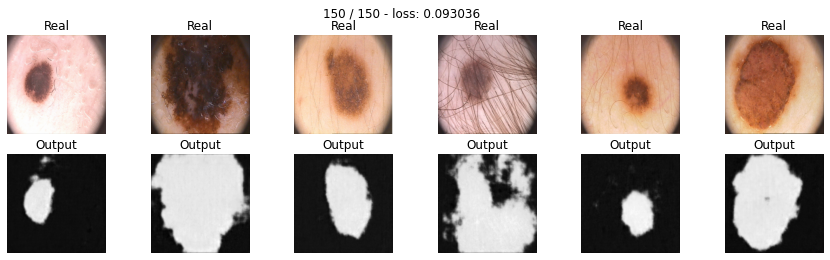

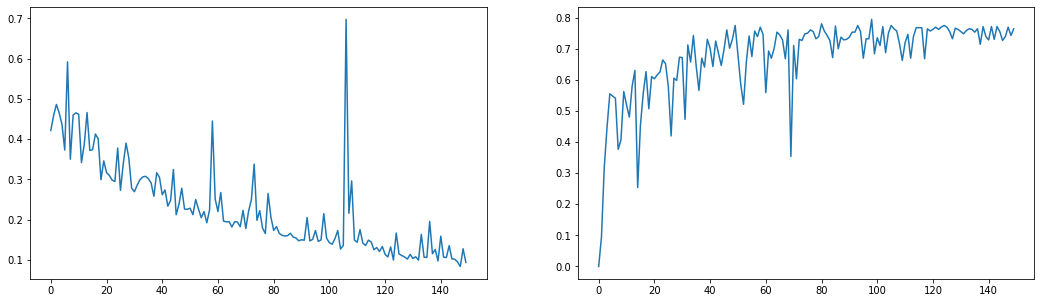

In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
max_epochs = 150
optim = torch.optim.AdamW(model.parameters(),lr=0.001)
history_seg_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
model_seg_bce=['seg_bce',score_model(model, iou_pytorch, data_val),score_model(model, iou_pytorch, data_ts)]
print(model_seg_bce)

['seg_bce', 0.7535714421953473, 0.7428571581840515]


По графикам на валидации, мы видим, что модель сходится примерно за 150 эпох. Score модели достигает значения 0.7964

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь 

 **В данном разделе применим модифицированые функции потерь.** 




**Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Так как эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска.Мы приблизить её с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$




In [ ]:
def dice_loss(y_real, y_pred):
    eps=1
    y_pred = torch.sigmoid(y_pred)
    num = 2.*(y_real*y_pred)
    den =  (y_real+y_pred)
    res = ((num+eps)/(den+eps))
    return 1-res.mean()

Проводим тестирование

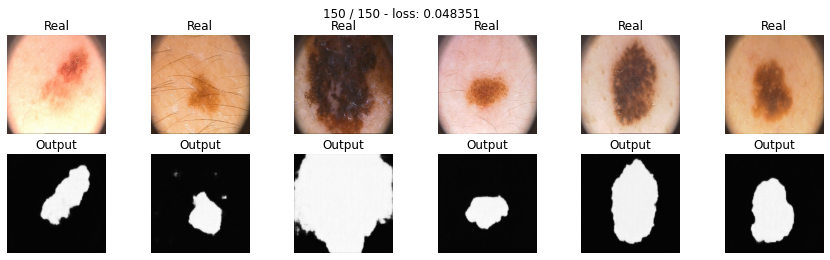

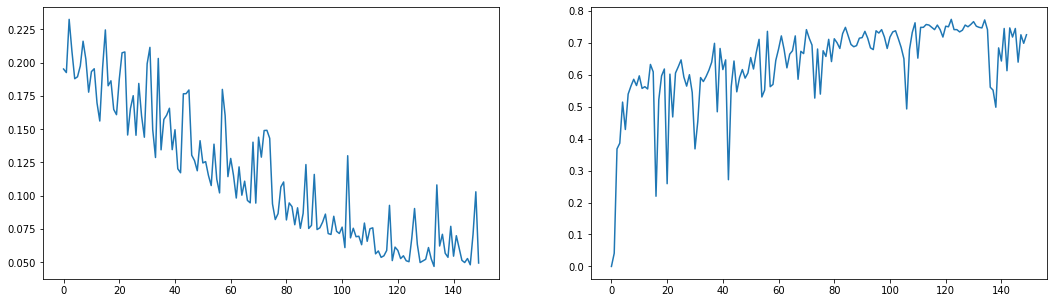

In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
model = SegNet().to(device)
optimaizer =  torch.optim.Adam(model.parameters())
max_epochs = 150

#optimaizer = optim.Adam(model_dice.parameters())
history_seg_dice = train(model, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
model_seg_dice=['seg_dice',score_model(model, iou_pytorch, data_val),score_model(model, iou_pytorch, data_ts)]
print(model_seg_dice)

['seg_dice', 0.7196428605488369, 0.7035714387893677]


Лосс не дал большого прироста в score, но график функции потерь получился более гладким.

[**Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 





Проблема  BCE loss заключается в том, что он имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
   # y_pred = F.sigmoid(y_pred)  # hint: torch.clamp
    BCE = bce_loss(y_pred, y_real)
    BCE_EXP = torch.exp(-abs(BCE))
    your_loss = (1-BCE_EXP)**gamma * BCE
    return your_loss

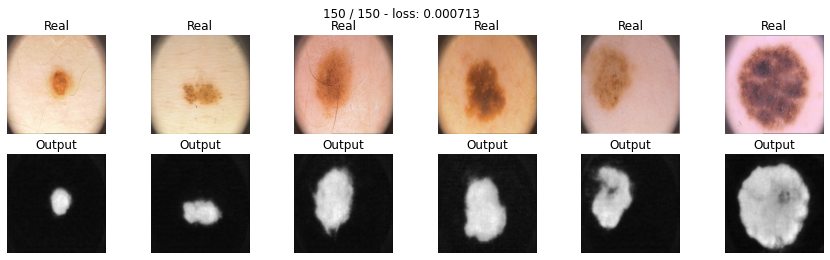

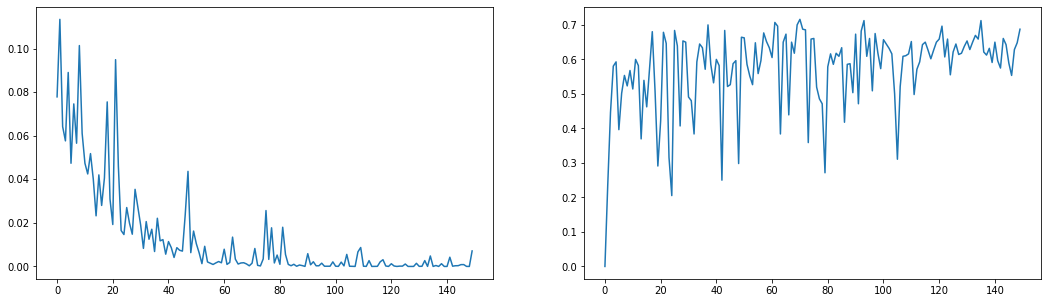

In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
model = SegNet().to(device)

max_epochs = 150
optimaizer = torch.optim.Adam(model.parameters())
history_focal_loss = train(model, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
model_seg_focal=['seg_focal',score_model(model, iou_pytorch, data_val),score_model(model, iou_pytorch, data_ts)]
print(model_seg_focal)

['seg_focal', 0.7089285850524902, 0.6821428622518267]


Мы видим что данный loss сходится намного быстрее(на 60 эпохе), но он сильно проигрывает в качестве предшественникам.

-----------------------------------------------------------------------------------------

# U-Net 

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Считывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

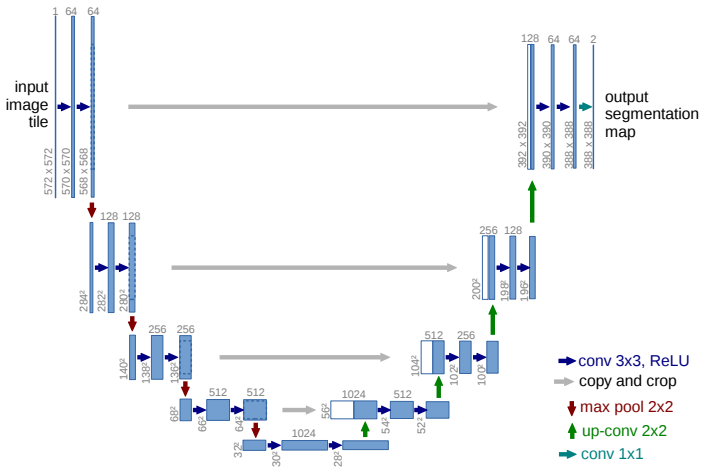

Отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def double_conv(in_channels, out_channels):
          return nn.Sequential(
                      nn.Conv2d(in_channels, out_channels, 3, padding=1),
                      nn.ReLU(inplace=True),
                       nn.BatchNorm2d(out_channels),
                      nn.Conv2d(out_channels, out_channels, 3, padding=1),
                       nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True))
        # encoder (downsampling)
        self.enc_conv0 = double_conv(3,16)

        self.pool0 =  nn.MaxPool2d(2) # 256 -> 128
        self.enc_conv1 = double_conv(16,32)
        self.pool1 =nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 = double_conv(32,64)
        self.pool2 =nn.MaxPool2d(2)    # 64 -> 32
        self.enc_conv3 =double_conv(64,128)
        self.pool3 =nn.MaxPool2d(2)    # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(inplace=True),
                                )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = double_conv(128*2 , 64)
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = double_conv(64*2, 32)
        self.upsample2 =nn.Upsample(scale_factor=2)   # 64 -> 128
        self.dec_conv2 = double_conv(32*2,16)
        self.upsample3 = nn.Upsample(scale_factor=2)   # 128 -> 256
        self.dec_conv3 = nn.Conv2d(16*2, 1, 3,padding=1)

    def forward(self, x):
        # encoder
        x = x.to(device)
        e0 =self.enc_conv0(x)
        x=  self.pool0(e0) 
        e1 = self.enc_conv1(x)
        x=  self.pool1(e1) 
        e2 = self.enc_conv2(x)
        x=  self.pool2(e2)
        e3 =self.enc_conv3(x)
        x=  self.pool3(e3)
        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        x = self.upsample0(b)
        x = torch.cat([x, e3], dim=1)
        d0 = self.dec_conv0(x)
        x = self.upsample1(d0)
        x = torch.cat([x, e2], dim=1)
        d1 = self.dec_conv1(x)
        x = self.upsample2(d1)
        x = torch.cat([x, e1], dim=1)
        d2 = self.dec_conv2(x)
        x = self.upsample3(d2)
        x = torch.cat([x, e0], dim=1)
        d3 = self.dec_conv3(x)  # no activation
        return d3

In [ ]:
model = UNet().to(device)

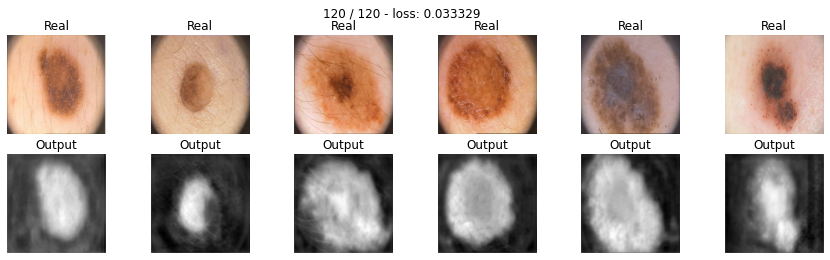

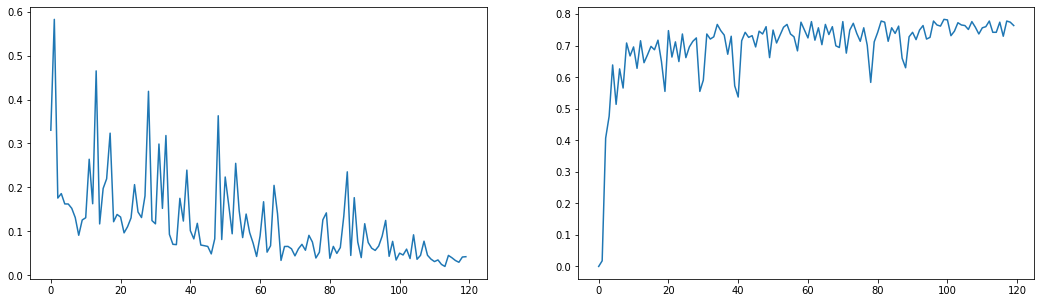

In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
history_bce_loss_u = train(model, torch.optim.Adam(model.parameters()), bce_loss, 120, data_tr, data_val)

In [ ]:
model_u_bce=['u_bce',score_model(model, iou_pytorch, data_val),score_model(model, iou_pytorch, data_ts)]
print(model_u_bce)

['u_bce', 0.7267857193946838, 0.7678571684019906]


Unet  неммного проигрывает в качестве, но сходится намного быстрее.

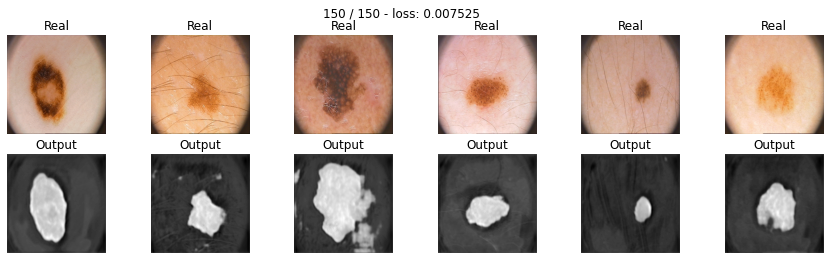

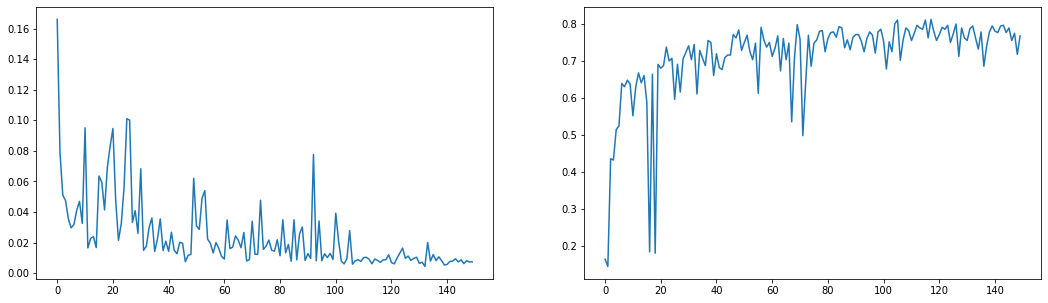

In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
model = UNet().to(device)
history_dice_loss_u = train(model, torch.optim.Adam(model.parameters()), dice_loss, 150, data_tr, data_val)

In [ ]:
model_u_dice=['u_dice',score_model(model, iou_pytorch, data_val),score_model(model, iou_pytorch, data_ts)]
print(model_u_dice)

['u_dice', 0.757142858845847, 0.7303571615900312]


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = F.sigmoid(y_pred)  # hint: torch.clamp
   # BCE = F.binary_cross_entropy(y_pred, y_real, reduction='mean')
    BCE = bce_loss(y_pred, y_real)
    BCE_EXP = torch.exp(-BCE)
    your_loss = (1-BCE_EXP)**gamma * BCE
    #L = y_pred - y_real*y_pred + torch.log(1+ torch.exp(-y_pred))                   
    loss = -((1-y_pred)**gamma*y_real* torch.log(y_pred)+(1-y_real)* torch.log(1-y_pred))
    #print(y_pred)
    return loss.mean()

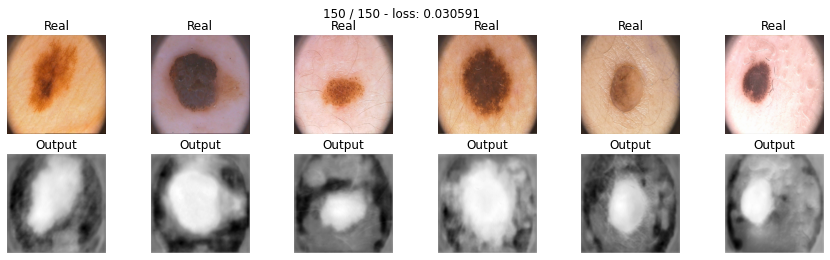

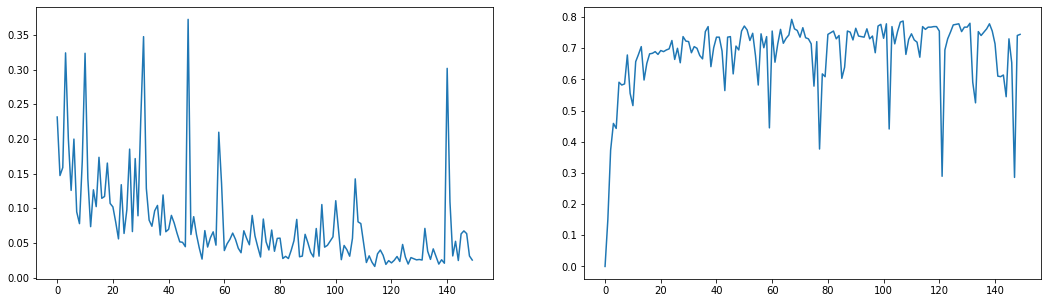

In [ ]:
ls_val = np.array([])
score_val = np.array([])
ls_tr = np.array([])
score_tr = np.array([])
model = UNet().to(device)
history_focal_loss_u= train(model, torch.optim.Adam(model.parameters()), focal_loss, 150, data_tr, data_val)

In [ ]:
model_u_focal=['model_u_focal',score_model(model, iou_pytorch, data_val),score_model(model, iou_pytorch, data_ts)]
print(model_u_focal)

['model_u_focal', 0.7446428537368774, 0.7589285884584699]


# Отчет 

In [ ]:
history = np.array([
history_seg_bce,'seg_bce',
history_seg_dice,'seg_dice',
history_focal_loss,'seg_focal',
history_bce_loss_u,'u_bce',
history_dice_loss_u, 'u_dice',
history_focal_loss_u, 'u_focal'])


<ipython-input-57-253687d317b1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  history = np.array([


In [ ]:
history[1]

'seg_bce'

<ipython-input-59-0f8874d4d532>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k)
<ipython-input-59-0f8874d4d532>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k+1)


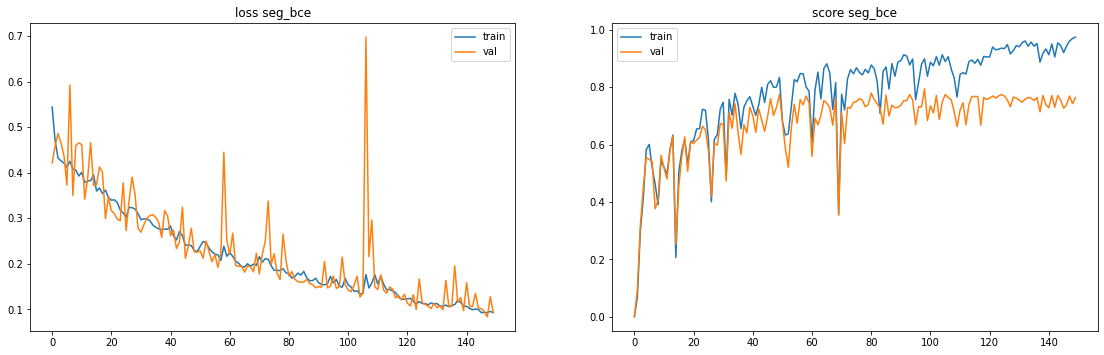

<ipython-input-59-0f8874d4d532>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k)
<ipython-input-59-0f8874d4d532>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k+1)


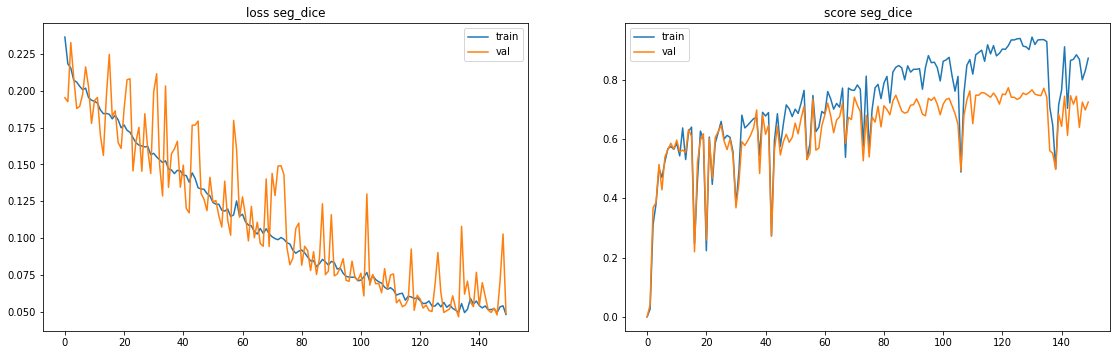

<ipython-input-59-0f8874d4d532>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k)
<ipython-input-59-0f8874d4d532>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k+1)


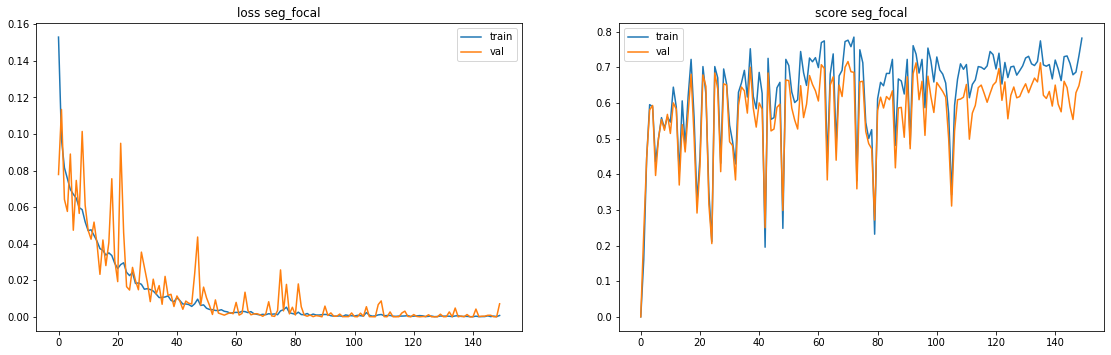

<ipython-input-59-0f8874d4d532>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k)
<ipython-input-59-0f8874d4d532>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k+1)


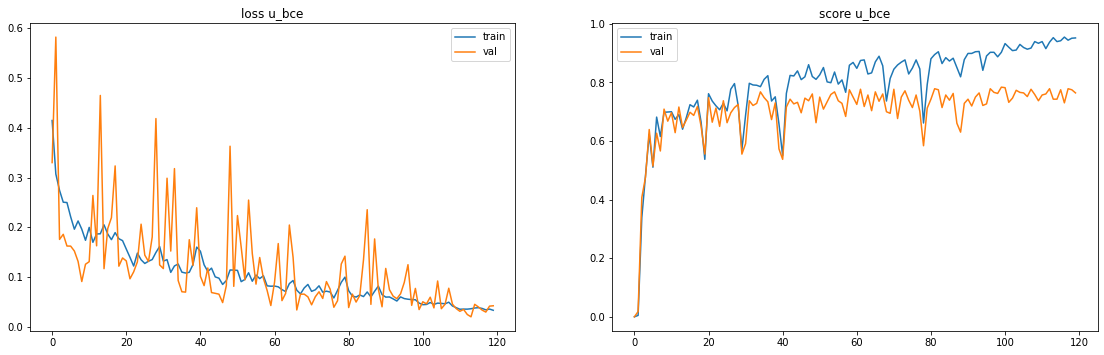

<ipython-input-59-0f8874d4d532>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k)
<ipython-input-59-0f8874d4d532>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k+1)


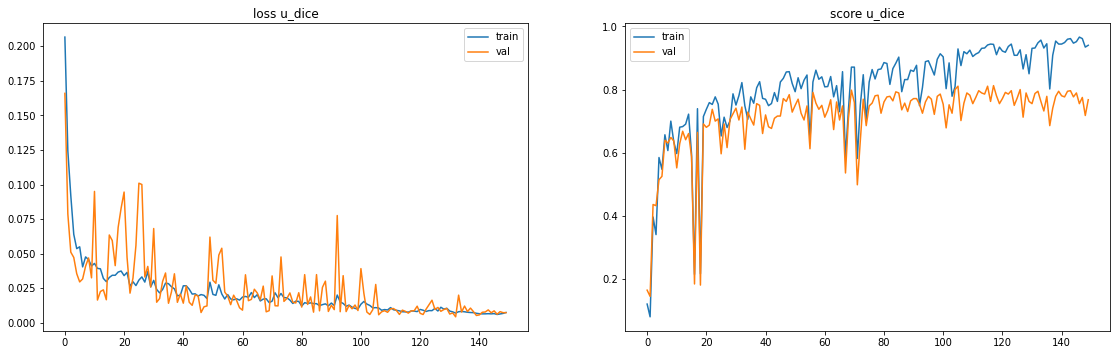

<ipython-input-59-0f8874d4d532>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k)
<ipython-input-59-0f8874d4d532>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(9,4, k+1)


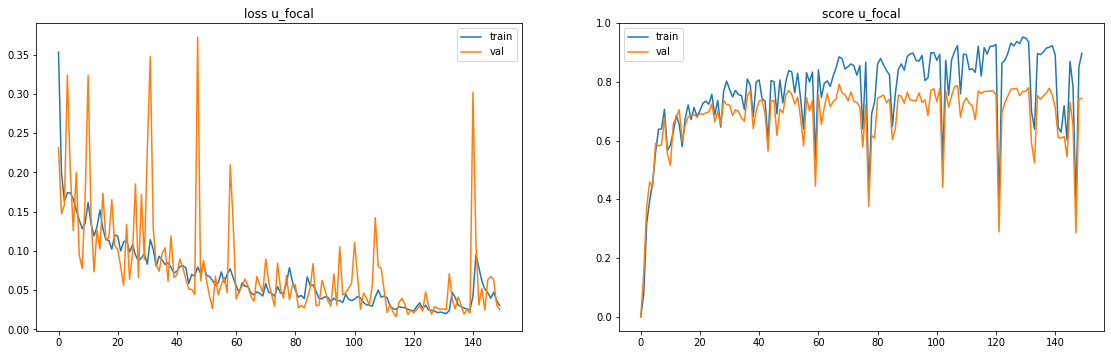

In [ ]:

k=1
for i in history:
  if k%2!=0:
    plt.figure(figsize=(40, 60))
    plt.subplot(9, 4, k)
    plt.plot(i[0], label='train')
    plt.title('loss '+history[k])
    plt.subplot(9,4, k)
    plt.plot(i[1], label='val')
    plt.legend(loc='best')
    plt.subplot(9, 4, k+1)
    plt.plot(i[2], label='train')
    plt.subplot(9,4, k+1)
    plt.plot(i[3], label='val')
    plt.legend(loc='best')
    plt.title('score '+history[k])
    plt.show()
  k+=1

Из графиков видно, что практически все модели не переобучаются. Сильные шумы на скоре связаны с маленьким размером батча,взятым всвязи с ограниченостью вычеслительных ресурсов. На unet  на всех лосах наблюдается самый сильный шум на валидации, это может быть связанно с слишком большим lr либо это просто особеность модели.

Теперь сравним функции потерь для каждой модели.

<ipython-input-60-a30931187ffd>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,2, 1)
<ipython-input-60-a30931187ffd>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 2, 1)
<ipython-input-60-a30931187ffd>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and r

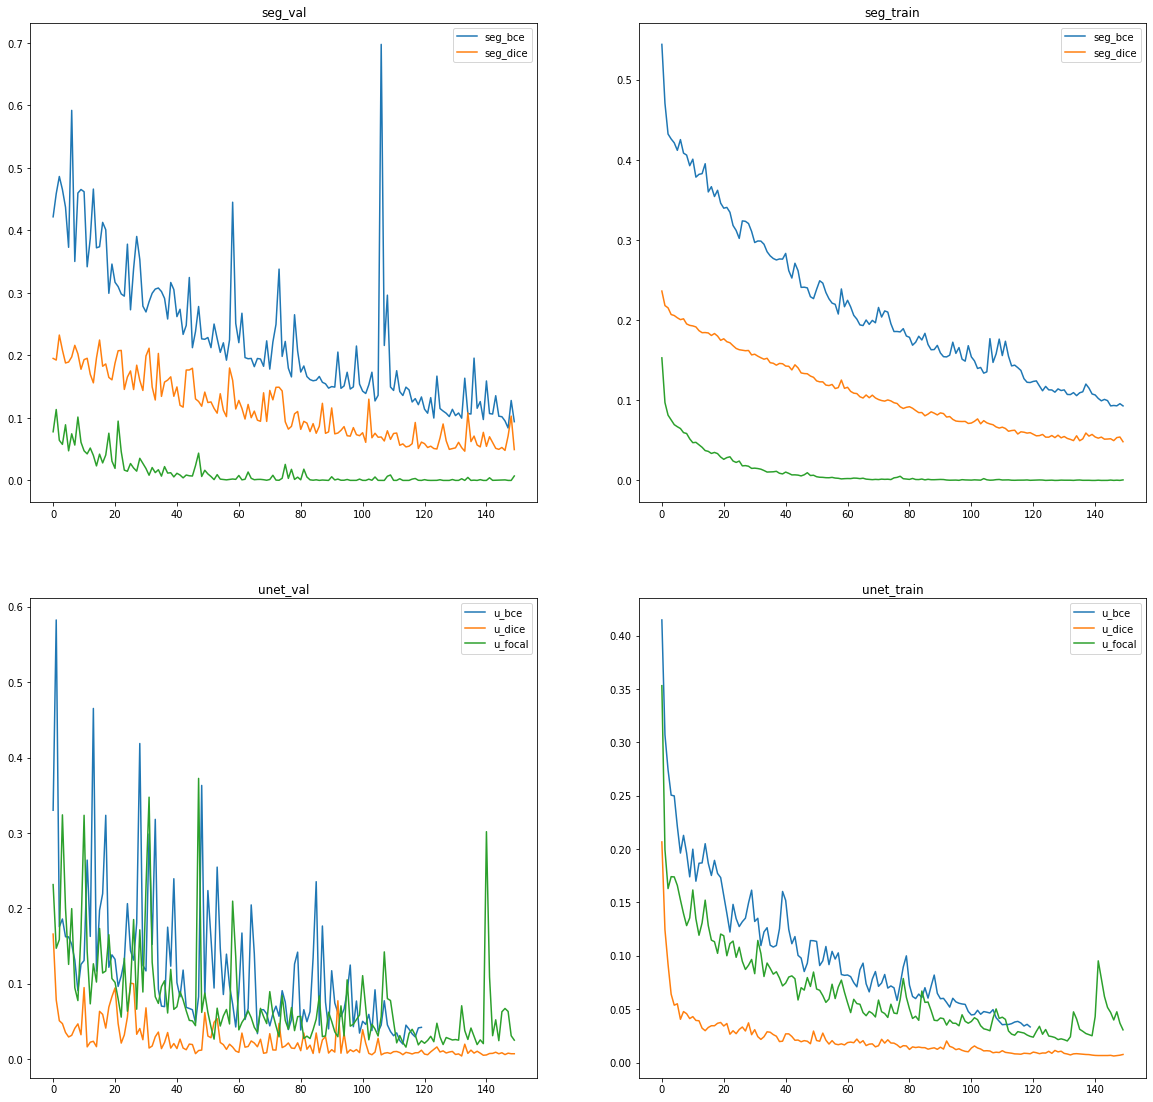

In [ ]:

plt.figure(figsize=(20, 30))
plt.subplot(3, 2, 1)
plt.plot(history[0][1], label=history[1])
plt.title('seg_val')
plt.subplot(3,2, 1)
plt.plot(history[2][1], label=history[3])
plt.legend(loc='best')
plt.subplot(3, 2, 1)
plt.plot(history[4][1], label=history[5])
plt.subplot(3,2, 1)

plt.subplot(3, 2, 2)
plt.plot(history[0][0], label=history[1])
plt.title('seg_train')
plt.subplot(3,2, 2)
plt.plot(history[2][0], label=history[3])
plt.legend(loc='best')
plt.subplot(3, 2, 2)
plt.plot(history[4][0], label=history[5])

plt.subplot(3, 2, 3)
plt.plot(history[6][1], label=history[7])
plt.title('unet_val')
plt.subplot(3,2, 3)
plt.plot(history[8][1], label=history[9])
plt.legend(loc='best')
plt.subplot(3, 2, 3)
plt.plot(history[10][1], label=history[11])
plt.legend(loc='best') 

plt.subplot(3, 2, 4)
plt.plot(history[6][0], label=history[7])
plt.title('unet_train')
plt.subplot(3,2, 4)
plt.plot(history[8][0], label=history[9])
plt.legend(loc='best')
plt.subplot(3, 2, 4)
plt.plot(history[10][0], label=history[11])
plt.legend(loc='best') 



Из графиков мы видим, focal_loss сходится за наименьшее количество эпох для segnet. Для unet более оптимально использовать dice_loss, так как он сходится значительно быстрее, к меньшим значениям и с меньшим шумом. 

Сравним модели по найденому лучшему loss.

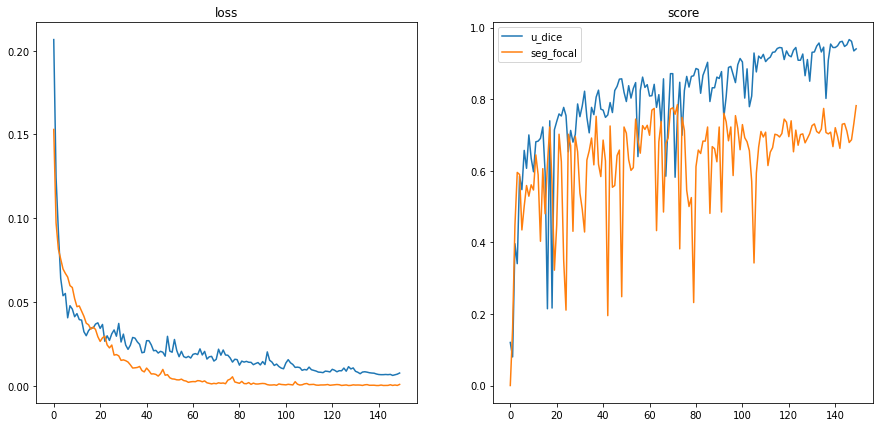

In [ ]:

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(history[8][0], label=history[9])
plt.plot(history[4][0], label=history[5])

plt.title('loss')
plt.subplot(1, 2, 2)
plt.plot(history[8][2], label=history[9])
plt.plot(history[4][2], label=history[5])
plt.title('score')
plt.legend(loc='best')   
plt.show()

Из графика можно сделать вывод, что для данной задачи с задаными параметрами lr и оптимизатором Adam лучше всех справляется с задачей unet с функцией потерь dice.

In [ ]:
!pip install tabulate
from tabulate import tabulate
#create data
data = [model_seg_bce, 
        model_seg_dice,
        model_seg_focal,
        model_u_bce, 
        model_u_dice,
        model_u_focal]
  
#define header names
col_names = ["Model name","Validation","Test"]

#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
╒═══════════════╤══════════════╤══════════╕
│ Model name    │   Validation │     Test │
╞═══════════════╪══════════════╪══════════╡
│ seg_bce       │     0.753571 │ 0.742857 │
├───────────────┼──────────────┼──────────┤
│ seg_dice      │     0.719643 │ 0.703571 │
├───────────────┼──────────────┼──────────┤
│ seg_focal     │     0.708929 │ 0.682143 │
├───────────────┼──────────────┼──────────┤
│ u_bce         │     0.726786 │ 0.767857 │
├───────────────┼──────────────┼──────────┤
│ u_dice        │     0.757143 │ 0.730357 │
├───────────────┼──────────────┼──────────┤
│ model_u_focal │     0.744643 │ 0.758929 │
╘═══════════════╧══════════════╧══════════╛
